<a href="https://colab.research.google.com/github/CodeMind-s/Final-Year-Research-25-26J-431/blob/Crystallization-Forecasting-model-Development/crystallization_forecasting_optimize_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# ============================================================
# SALT CRYSTALLIZATION FORECASTING MODEL
# ARIMA + LSTM Hybrid with Weather API Integration
# ============================================================

# Install required packages
!pip install pmdarima openpyxl tensorflow pandas numpy scikit-learn requests matplotlib -q

In [17]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [18]:
# ============================================================
# 1. WEATHER API INTEGRATION
# ============================================================

def fetch_weather_data(latitude=8.062652, longitude=79.816651, past_days=31, forecast_days=16):
    """
    Fetch weather data from Open-Meteo API
    Note: API limits - past_days max 92, forecast_days max 16
    """
    url = "https://api.open-meteo.com/v1/forecast"

    # Ensure we don't exceed API limits
    past_days = min(past_days, 92)
    forecast_days = min(forecast_days, 16)

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "daily": ",".join([
            "temperature_2m_max", "temperature_2m_min", "wind_speed_10m_max",
            "wind_gusts_10m_max", "rain_sum", "weather_code", "temperature_2m_mean",
            "wind_gusts_10m_mean", "wind_speed_10m_mean", "wind_gusts_10m_min",
            "wind_speed_10m_min", "relative_humidity_2m_mean",
            "relative_humidity_2m_max", "relative_humidity_2m_min"
        ]),
        "timezone": "auto",
        "past_days": past_days,
        "forecast_days": forecast_days
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        # Convert to DataFrame
        weather_df = pd.DataFrame({
            'date': pd.to_datetime(data['daily']['time']),
            'temperature_mean': data['daily']['temperature_2m_mean'],
            'temperature_max': data['daily']['temperature_2m_max'],
            'temperature_min': data['daily']['temperature_2m_min'],
            'wind_speed_max': data['daily']['wind_speed_10m_max'],
            'wind_gusts_max': data['daily']['wind_gusts_10m_max'],
            'rain_sum': data['daily']['rain_sum'],
            'wind_gusts_mean': data['daily']['wind_gusts_10m_mean'],
            'wind_speed_mean': data['daily']['wind_speed_10m_mean'],
            'wind_gusts_min': data['daily']['wind_gusts_10m_min'],
            'wind_speed_min': data['daily']['wind_speed_10m_min'],
            'weather_code': data['daily']['weather_code'],
            'relative_humidity_mean': data['daily']['relative_humidity_2m_mean'],
            'relative_humidity_max': data['daily']['relative_humidity_2m_max'],
            'relative_humidity_min': data['daily']['relative_humidity_2m_min']
        })

        print(f"✓ Weather data fetched: {len(weather_df)} days")
        return weather_df

    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return None


In [19]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# 2. DATA LOADING AND PREPROCESSING
# ============================================================

def load_and_preprocess_data():
    """
    Load all data files and preprocess them
    """
    print("="*60)
    print("LOADING DATA")
    print("="*60)

    # Try multiple encodings
    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']

    def read_csv_with_encoding(filename):
        for encoding in encodings:
            try:
                df = pd.read_csv(filename, encoding=encoding)
                print(f"✓ Loaded {filename} with {encoding} encoding")
                return df
            except UnicodeDecodeError:
                continue
            except Exception as e:
                print(f"Error with {encoding}: {e}")
                continue
        raise ValueError(f"Could not read {filename} with any encoding")

    # Load data files
    log_df = read_csv_with_encoding('log_data_total.csv')
    weather_df = read_csv_with_encoding('weather_data_total.csv')
    agg_df = read_csv_with_encoding('aggregated_data_total.csv')
    prod_df = read_csv_with_encoding('production_data_total.csv')

    # Clean column names (remove extra spaces and units) for all DFs
    log_df.columns = log_df.columns.str.strip()
    weather_df.columns = weather_df.columns.str.strip().str.replace(r'\s*\(.*\)', '', regex=True) # Remove (units)
    prod_df.columns = prod_df.columns.str.strip()
    agg_df.columns = agg_df.columns.str.strip()

    # Drop 'Unnamed' columns if they exist (e.g., 'Unnamed: 9')
    log_df = log_df.loc[:, ~log_df.columns.str.contains('^Unnamed')]
    weather_df = weather_df.loc[:, ~weather_df.columns.str.contains('^Unnamed')] # Defensive

    # Process dates - handle different date formats
    # Now that column names are stripped, 'date' and 'month' columns should be consistently named
    for df, date_col_name in [(log_df, 'date'), (weather_df, 'date'), (prod_df, 'month'), (agg_df, 'month')]:
        if date_col_name in df.columns:
            df[date_col_name] = pd.to_datetime(df[date_col_name], errors='coerce')

    # Remove rows with invalid dates after conversion
    log_df = log_df.dropna(subset=['date'])
    weather_df = weather_df.dropna(subset=['date'])
    prod_df = prod_df.dropna(subset=['month'])
    agg_df = agg_df.dropna(subset=['month'])

    # Sort by date
    log_df = log_df.sort_values('date').reset_index(drop=True)
    weather_df = weather_df.sort_values('date').reset_index(drop=True)
    prod_df = prod_df.sort_values('month').reset_index(drop=True)

    print(f"\nColumn names in log_df: {log_df.columns.tolist()}")
    print(f"Column names in weather_df: {weather_df.columns.tolist()}")

    # Merge log data with weather data
    merged_df = pd.merge(log_df, weather_df, on='date', how='left')

    # Fill missing values
    merged_df = merged_df.fillna(method='ffill').fillna(method='bfill')

    print(f"✓ Log data: {log_df.shape}")
    print(f"✓ Weather data: {weather_df.shape}")
    print(f"✓ Production data: {prod_df.shape}")
    print(f"✓ Merged data: {merged_df.shape}")

    return log_df, weather_df, prod_df, agg_df, merged_df

In [20]:
# ============================================================
# 3. SEASON DETECTION
# ============================================================

def get_season(month):
    """
    Determine Yala or Maha season based on month
    Yala: May-August (5-8)
    Maha: November-February (11-12, 1-2)
    """
    if month in [5, 6, 7, 8]:
        return 'Yala'
    elif month in [11, 12, 1, 2]:
        return 'Maha'
    else:
        return 'Other'

In [21]:
# ============================================================
# 4. DATA AUGMENTATION
# ============================================================

def augment_data(data, noise_levels=[0.01, 0.015, 0.02]):
    """
    Create augmented versions with different noise levels
    """
    augmented_list = [data]

    for noise_level in noise_levels:
        noise = np.random.normal(0, noise_level, data.shape)
        augmented = data + noise
        augmented_list.append(augmented)

    return np.vstack(augmented_list)

In [22]:
# ============================================================
# 5. SEQUENCE CREATION WITH WEATHER FEATURES
# ============================================================

def create_sequences_with_weather(log_data, weather_data, lookback=30, forecast_horizon=60):
    """
    Create sequences including weather features
    """
    X_log, X_weather, Y = [], [], []

    for i in range(len(log_data) - lookback - forecast_horizon + 1):
        # Log parameters sequence (input)
        X_log.append(log_data[i:(i + lookback), :])

        # Weather features for the same period
        X_weather.append(weather_data[i:(i + lookback), :])

        # Target: next 60 days of log parameters
        Y.append(log_data[(i + lookback):(i + lookback + forecast_horizon), :])

    return np.array(X_log), np.array(X_weather), np.array(Y)

In [23]:
# ============================================================
# 6. BUILD HYBRID LSTM MODEL WITH WEATHER INTEGRATION
# ============================================================

def build_hybrid_lstm_model(lookback, n_log_features, n_weather_features,
                            forecast_horizon, lstm_units=[128, 64],
                            dropout_rate=0.3, l2_reg=0.001):
    """
    Build hybrid LSTM model with separate branches for log and weather data
    """
    # Log parameters input
    log_input = Input(shape=(lookback, n_log_features), name='log_input')

    # Weather features input
    weather_input = Input(shape=(lookback, n_weather_features), name='weather_input')

    # Log parameters branch
    x1 = Bidirectional(LSTM(lstm_units[0], return_sequences=True,
                            kernel_regularizer=l2(l2_reg)))(log_input)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(dropout_rate)(x1)
    x1 = Bidirectional(LSTM(lstm_units[1], return_sequences=False,
                            kernel_regularizer=l2(l2_reg)))(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(dropout_rate)(x1)

    # Weather features branch
    x2 = Bidirectional(LSTM(64, return_sequences=True,
                            kernel_regularizer=l2(l2_reg)))(weather_input)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(dropout_rate)(x2)
    x2 = Bidirectional(LSTM(32, return_sequences=False,
                            kernel_regularizer=l2(l2_reg)))(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(dropout_rate)(x2)

    # Concatenate both branches
    combined = Concatenate()([x1, x2])

    # Dense layers
    x = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(combined)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)

    # Output layer
    outputs = Dense(forecast_horizon * n_log_features)(x)

    model = Model(inputs=[log_input, weather_input], outputs=outputs)

    return model

In [24]:
# ============================================================
# 7. MAIN TRAINING PIPELINE
# ============================================================

def train_models():
    """
    Main training pipeline
    """
    # Load data
    log_df, weather_df, prod_df, agg_df, merged_df = load_and_preprocess_data()

    # Define features
    log_features = ['water_temperature', 'lagoon', 'OR_brine_level', 'OR_bund_level',
                    'IR_brine_level', 'IR_bound_level', 'East_channel', 'West_channel']

    weather_features = ['temperature_mean', 'temperature_max', 'temperature_min',
                       'wind_speed_max', 'wind_gusts_max', 'rain_sum',
                       'relative_humidity_mean']

    # Extract data
    log_data = merged_df[log_features].values
    weather_data = merged_df[weather_features].values

    # Scale data
    log_scaler = RobustScaler()
    weather_scaler = RobustScaler()

    log_scaled = log_scaler.fit_transform(log_data)
    weather_scaled = weather_scaler.fit_transform(weather_data)

    print("\n" + "="*60)
    print("DATA AUGMENTATION")
    print("="*60)

    # Augment data
    log_augmented = augment_data(log_scaled, noise_levels=[0.01, 0.015])
    weather_augmented = augment_data(weather_scaled, noise_levels=[0.01, 0.015])

    print(f"Original size: {log_scaled.shape}")
    print(f"Augmented size: {log_augmented.shape}")

    # Create sequences
    lookback = 30
    forecast_horizon = 60

    X_log, X_weather, Y = create_sequences_with_weather(
        log_augmented, weather_augmented, lookback, forecast_horizon
    )

    Y_reshaped = Y.reshape(Y.shape[0], forecast_horizon * len(log_features))

    # Train/Val/Test split (70/15/15)
    # First split: 85% train+val, 15% test
    X_log_temp, X_log_test, X_weather_temp, X_weather_test, Y_temp, Y_test = train_test_split(
        X_log, X_weather, Y_reshaped, test_size=0.15, random_state=42, shuffle=False
    )

    # Second split: from remaining 85%, take 15% for validation
    X_log_train, X_log_val, X_weather_train, X_weather_val, Y_train, Y_val = train_test_split(
        X_log_temp, X_weather_temp, Y_temp, test_size=0.176, random_state=42, shuffle=False
    )

    print("\n" + "="*60)
    print("DATA SPLIT")
    print("="*60)
    print(f"Training samples: {X_log_train.shape[0]}")
    print(f"Validation samples: {X_log_val.shape[0]}")
    print(f"Test samples: {X_log_test.shape[0]}")

    # Build model
    print("\n" + "="*60)
    print("BUILDING LSTM MODEL")
    print("="*60)

    model = build_hybrid_lstm_model(
        lookback=lookback,
        n_log_features=len(log_features),
        n_weather_features=len(weather_features),
        forecast_horizon=forecast_horizon,
        lstm_units=[128, 64],
        dropout_rate=0.3,
        l2_reg=0.001
    )

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
        ModelCheckpoint('best_hybrid_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    ]

    # Train model
    print("\n" + "="*60)
    print("TRAINING MODEL")
    print("="*60)

    history = model.fit(
        [X_log_train, X_weather_train], Y_train,
        validation_data=([X_log_val, X_weather_val], Y_val),
        epochs=150,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate on test set
    print("\n" + "="*60)
    print("MODEL EVALUATION ON TEST SET")
    print("="*60)

    # Get predictions for test set
    Y_pred_test = model.predict([X_log_test, X_weather_test], verbose=0)

    # Calculate metrics
    test_loss, test_mae = model.evaluate([X_log_test, X_weather_test], Y_test, verbose=0)
    test_rmse = np.sqrt(test_loss)
    test_r2 = r2_score(Y_test, Y_pred_test)

    # Calculate MAPE safely (avoid division by very small numbers)
    epsilon = 1e-7
    test_mape = np.mean(np.abs((Y_test - Y_pred_test) / (np.abs(Y_test) + epsilon))) * 100

    # Better accuracy calculation based on R² score
    # R² ranges from -inf to 1, where 1 is perfect prediction
    # Convert to percentage: accuracy = max(0, min(100, R² * 100))
    test_accuracy = max(0, min(100, test_r2 * 100))

    print(f"{'='*60}")
    print("MODEL PERFORMANCE SUMMARY")
    print(f"{'='*60}")
    print(f"Test Loss (MSE):              {test_loss:.6f}")
    print(f"Test RMSE:                    {test_rmse:.6f}")
    print(f"Test MAE:                     {test_mae:.6f}")
    print(f"Test R² Score:                {test_r2:.6f}")
    print(f"Test MAPE:                    {test_mape:.2f}%")
    print(f"Test Accuracy (R²-based):     {test_accuracy:.2f}%")
    print(f"{'='*60}")

    # Evaluate on validation set
    Y_pred_val = model.predict([X_log_val, X_weather_val], verbose=0)
    val_loss, val_mae = model.evaluate([X_log_val, X_weather_val], Y_val, verbose=0)
    val_rmse = np.sqrt(val_loss)
    val_r2 = r2_score(Y_val, Y_pred_val)
    val_mape = np.mean(np.abs((Y_val - Y_pred_val) / (np.abs(Y_val) + epsilon))) * 100
    val_accuracy = max(0, min(100, val_r2 * 100))

    print(f"\nVALIDATION SET PERFORMANCE")
    print(f"{'='*60}")
    print(f"Validation Loss (MSE):        {val_loss:.6f}")
    print(f"Validation RMSE:              {val_rmse:.6f}")
    print(f"Validation MAE:               {val_mae:.6f}")
    print(f"Validation R² Score:          {val_r2:.6f}")
    print(f"Validation MAPE:              {val_mape:.2f}%")
    print(f"Validation Accuracy (R²-based): {val_accuracy:.2f}%")
    print(f"{'='*60}")

    # Evaluate on training set
    Y_pred_train = model.predict([X_log_train, X_weather_train], verbose=0)
    train_loss, train_mae = model.evaluate([X_log_train, X_weather_train], Y_train, verbose=0)
    train_rmse = np.sqrt(train_loss)
    train_r2 = r2_score(Y_train, Y_pred_train)
    train_mape = np.mean(np.abs((Y_train - Y_pred_train) / (np.abs(Y_train) + epsilon))) * 100
    train_accuracy = max(0, min(100, train_r2 * 100))

    print(f"\nTRAINING SET PERFORMANCE")
    print(f"{'='*60}")
    print(f"Training Loss (MSE):          {train_loss:.6f}")
    print(f"Training RMSE:                {train_rmse:.6f}")
    print(f"Training MAE:                 {train_mae:.6f}")
    print(f"Training R² Score:            {train_r2:.6f}")
    print(f"Training MAPE:                {train_mape:.2f}%")
    print(f"Training Accuracy (R²-based): {train_accuracy:.2f}%")
    print(f"{'='*60}")

    # Create metrics dictionary for later use
    metrics = {
        'train': {'loss': train_loss, 'rmse': train_rmse, 'mae': train_mae,
                  'r2': train_r2, 'mape': train_mape, 'accuracy': train_accuracy},
        'val': {'loss': val_loss, 'rmse': val_rmse, 'mae': val_mae,
                'r2': val_r2, 'mape': val_mape, 'accuracy': val_accuracy},
        'test': {'loss': test_loss, 'rmse': test_rmse, 'mae': test_mae,
                 'r2': test_r2, 'mape': test_mape, 'accuracy': test_accuracy}
    }

    # Train ARIMA for production forecast
    print("\n" + "="*60)
    print("TRAINING ARIMA FOR PRODUCTION")
    print("="*60)

    production_series = prod_df.set_index('month')['production_volume']

    print(f"Production data summary:")
    print(f"  - Total months: {len(production_series)}")
    print(f"  - Mean: {production_series.mean():.2f}")
    print(f"  - Std: {production_series.std():.2f}")
    print(f"  - Min: {production_series.min():.2f}, Max: {production_series.max():.2f}")

    arima_model = auto_arima(
        production_series,
        start_p=1, start_q=1,
        max_p=5, max_q=5,
        d=None,  # Auto-detect differencing
        start_P=1, start_Q=1,
        max_P=3, max_Q=3,
        D=None,  # Auto-detect seasonal differencing
        seasonal=True,
        m=12,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        approximation=False,  # More thorough search
        n_jobs=-1,
        information_criterion='aic'
    )

    print(f"\nBest ARIMA: {arima_model.order} x {arima_model.seasonal_order}")
    print(f"AIC: {arima_model.aic():.2f}")

    # Verify model by fitting and showing residual statistics
    fitted_values = arima_model.predict_in_sample()
    residuals = production_series - fitted_values
    print(f"Residuals mean: {residuals.mean():.4f} (should be close to 0)")
    print(f"Residuals std: {residuals.std():.2f}")

    return model, arima_model, log_scaler, weather_scaler, log_features, weather_features, history, prod_df, metrics


In [25]:
# ============================================================
# 8. FORECASTING FUNCTION
# ============================================================

def forecast_parameters(model, log_scaler, weather_scaler, log_features,
                       weather_features, current_date, current_log_values,
                       lookback=30, forecast_days=60):
    """
    Forecast parameters for next 2 months with weather API integration

    Parameters:
    - model: trained LSTM model
    - current_date: starting date for forecast (string or datetime)
    - current_log_values: dict with current values of log parameters
    """
    print("\n" + "="*60)
    print("PARAMETER FORECASTING")
    print("="*60)

    # Convert date
    if isinstance(current_date, str):
        current_date = pd.to_datetime(current_date)

    # Fetch weather forecast (API max is 16 days forecast)
    weather_forecast = fetch_weather_data(past_days=lookback-1, forecast_days=16)

    if weather_forecast is None:
        print("Error: Could not fetch weather data")
        return None

    # Prepare log sequence (last 30 days)
    # For demonstration, we'll use current values repeated
    # In practice, you'd use actual historical data
    log_sequence = np.array([[
        current_log_values['water_temperature'],
        current_log_values['lagoon'],
        current_log_values['OR_brine_level'],
        current_log_values['OR_bund_level'],
        current_log_values['IR_brine_level'],
        current_log_values['IR_bound_level'],
        current_log_values['East_channel'],
        current_log_values['West_channel']
    ]] * lookback)

    # Scale log data
    log_scaled = log_scaler.transform(log_sequence)

    # Prepare weather sequence
    weather_cols = ['temperature_mean', 'temperature_max', 'temperature_min',
                   'wind_speed_max', 'wind_gusts_max', 'rain_sum',
                   'relative_humidity_mean']

    weather_sequence = weather_forecast[weather_cols].head(lookback).values
    weather_scaled = weather_scaler.transform(weather_sequence)

    # For forecasting beyond 16 days, we'll use iterative prediction
    all_predictions = []
    current_log_input = log_scaled.copy()

    # Get the last 16 days of weather data for future forecasting
    weather_future = weather_forecast[weather_cols].tail(16).values

    print(f"✓ Forecasting {forecast_days} days in batches...")

    # Predict in chunks
    remaining_days = forecast_days
    iteration = 0

    while remaining_days > 0:
        iteration += 1
        current_forecast_days = min(remaining_days, 60)

        # Prepare weather input
        if iteration == 1:
            # First iteration: use actual weather forecast
            current_weather_input = weather_scaled.reshape(1, lookback, len(weather_features))
        else:
            # Subsequent iterations: repeat last known weather pattern
            last_weather = weather_scaled[-1:].repeat(lookback, axis=0)
            current_weather_input = last_weather.reshape(1, lookback, len(weather_features))

        # Prepare log input
        current_log_input_reshaped = current_log_input[-lookback:].reshape(1, lookback, len(log_features))

        # Predict
        prediction = model.predict([current_log_input_reshaped, current_weather_input], verbose=0)
        prediction_reshaped = prediction.reshape(60, len(log_features))

        # Take only what we need
        days_to_take = min(current_forecast_days, 60)
        all_predictions.append(prediction_reshaped[:days_to_take])

        # Update current_log_input for next iteration
        current_log_input = np.vstack([current_log_input, prediction_reshaped[:days_to_take]])

        remaining_days -= days_to_take
        print(f"  Iteration {iteration}: Predicted {days_to_take} days")

    # Combine all predictions
    final_predictions = np.vstack(all_predictions)

    # Inverse transform
    prediction_original = log_scaler.inverse_transform(final_predictions)

    # Create forecast dataframe
    forecast_dates = pd.date_range(start=current_date + timedelta(days=1),
                                   periods=forecast_days, freq='D')

    forecast_df = pd.DataFrame(prediction_original, columns=log_features)
    forecast_df['date'] = forecast_dates

    # Add weather forecast for first 16 days (rest will be extrapolated)
    weather_future_extended = np.tile(weather_future[-1], (forecast_days, 1))
    weather_future_extended[:min(16, forecast_days)] = weather_future[:min(16, forecast_days)]

    weather_future_df = pd.DataFrame(weather_future_extended, columns=weather_cols)
    forecast_df = pd.concat([forecast_df.reset_index(drop=True), weather_future_df.reset_index(drop=True)], axis=1)

    print(f"✓ Successfully forecasted {forecast_days} days of parameters")
    print(f"\n{'='*60}")
    print("FIRST 10 DAYS FORECAST:")
    print(f"{'='*60}")
    # print(forecast_df.head(10).to_string())
    print(forecast_df.head(60).to_string())
    print(f"\n{'='*60}")
    # print("LAST 10 DAYS FORECAST:")
    # print(f"{'='*60}")
    # print(forecast_df.tail(10).to_string())

    return forecast_df


In [26]:
# ============================================================
# 9. PRODUCTION FORECASTING
# ============================================================

def forecast_production(arima_model, prod_df, forecast_months=6):
    """
    Forecast monthly production with trend and variability
    """
    print("\n" + "="*60)
    print("PRODUCTION FORECASTING")
    print("="*60)

    production_series = prod_df.set_index('month')['production_volume']

    # Forecast with confidence intervals
    forecast, conf_int = arima_model.predict(n_periods=forecast_months, return_conf_int=True)

    # Add some realistic variation if forecast is too flat
    # Check if forecast has low variance
    if len(forecast) > 1 and np.std(forecast) < np.std(production_series) * 0.1:
        print("⚠ Warning: Forecast appears flat. Adding trend from historical data...")
        # Calculate historical trend
        hist_trend = np.polyfit(range(len(production_series)), production_series, deg=1)[0]
        # Apply trend to forecast
        for i in range(len(forecast)):
            forecast[i] += hist_trend * i
            # Ensure non-negative
            forecast[i] = max(0, forecast[i])

    # Create forecast index
    last_month = production_series.index[-1]
    forecast_index = pd.date_range(
        last_month + pd.offsets.MonthBegin(),
        periods=forecast_months,
        freq='MS'
    )

    forecast_df = pd.DataFrame({
        'month': forecast_index,
        'production_forecast': forecast,
        'lower_bound': conf_int[:, 0],
        'upper_bound': conf_int[:, 1]
    })

    print(f"✓ Forecasted {forecast_months} months of production")
    print(f"  - Mean forecast: {forecast.mean():.2f}")
    print(f"  - Forecast std: {np.std(forecast):.2f}")
    print(f"  - Historical std: {production_series.std():.2f}")
    print("\nMonthly Production Forecast:")
    print(forecast_df)

    return forecast_df

In [27]:
# ============================================================
# 10. SEASONAL PRODUCTION FORECASTING
# ============================================================

def forecast_seasonal_production(arima_model, prod_df, forecast_months=12):
    """
    Forecast Yala and Maha season total production for next 12 months
    """
    print("\n" + "="*60)
    print("SEASONAL PRODUCTION FORECASTING")
    print("="*60)

    # Get monthly forecast
    monthly_forecast = forecast_production(arima_model, prod_df, forecast_months)

    # Add season column
    monthly_forecast['season'] = monthly_forecast['month'].dt.month.apply(get_season)

    # Calculate seasonal totals
    seasonal_totals = monthly_forecast[monthly_forecast['season'] != 'Other'].groupby('season')['production_forecast'].sum()

    print("\nSeasonal Production Forecast (Next 12 Months):")
    print(f"Yala Season Total: {seasonal_totals.get('Yala', 0):.2f}")
    print(f"Maha Season Total: {seasonal_totals.get('Maha', 0):.2f}")

    return seasonal_totals, monthly_forecast

In [28]:
# ============================================================
# 11. VISUALIZATION
# ============================================================

def plot_results(history, prod_df, monthly_forecast, metrics=None, parameter_forecast=None):
    """
    Plot training history and forecasts
    """
    # Training history
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history['mae'], label='Training MAE')
    axes[1].plot(history.history['val_mae'], label='Validation MAE')
    axes[1].set_title('Model MAE', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Model Accuracy Comparison
    if metrics is not None:
        try:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))

            # Accuracy comparison
            datasets = ['Training', 'Validation', 'Test']
            accuracies = [
                max(0, min(100, metrics['train']['accuracy'])),
                max(0, min(100, metrics['val']['accuracy'])),
                max(0, min(100, metrics['test']['accuracy']))
            ]
            colors = ['#2ecc71', '#3498db', '#e74c3c']

            axes[0].bar(datasets, accuracies, color=colors, alpha=0.7, edgecolor='black')
            axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
            axes[0].set_ylabel('Accuracy (%)')
            axes[0].set_ylim([0, 105])
            axes[0].grid(True, alpha=0.3, axis='y')
            for i, v in enumerate(accuracies):
                if v >= 0 and v <= 100:
                    axes[0].text(i, v + 2, f'{v:.2f}%', ha='center', fontweight='bold')

            # R² Score comparison
            r2_scores = [
                max(-1, min(1, metrics['train']['r2'])),
                max(-1, min(1, metrics['val']['r2'])),
                max(-1, min(1, metrics['test']['r2']))
            ]
            axes[1].bar(datasets, r2_scores, color=colors, alpha=0.7, edgecolor='black')
            axes[1].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
            axes[1].set_ylabel('R² Score')
            axes[1].set_ylim([-0.1, 1.1])
            axes[1].grid(True, alpha=0.3, axis='y')
            for i, v in enumerate(r2_scores):
                if v >= -1 and v <= 1:
                    axes[1].text(i, v + 0.05, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

            # Error metrics comparison
            x = np.arange(len(datasets))
            width = 0.25

            rmse_values = [
                metrics['train']['rmse'],
                metrics['val']['rmse'],
                metrics['test']['rmse']
            ]
            mae_values = [
                metrics['train']['mae'],
                metrics['val']['mae'],
                metrics['test']['mae']
            ]

            # Filter out invalid values
            rmse_values = [v if np.isfinite(v) and v >= 0 else 0 for v in rmse_values]
            mae_values = [v if np.isfinite(v) and v >= 0 else 0 for v in mae_values]

            axes[2].bar(x - width/2, rmse_values, width, label='RMSE', color='#e67e22', alpha=0.7, edgecolor='black')
            axes[2].bar(x + width/2, mae_values, width, label='MAE', color='#9b59b6', alpha=0.7, edgecolor='black')
            axes[2].set_title('Error Metrics Comparison', fontsize=14, fontweight='bold')
            axes[2].set_ylabel('Error Value')
            axes[2].set_xticks(x)
            axes[2].set_xticklabels(datasets)
            axes[2].legend()
            axes[2].grid(True, alpha=0.3, axis='y')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Warning: Could not display accuracy charts: {e}")
            print("Continuing with other visualizations...")

    # Production forecast
    plt.figure(figsize=(14, 6))
    production_series = prod_df.set_index('month')['production_volume']
    plt.plot(production_series.index, production_series,
             label='Historical Production', linewidth=2, marker='o')
    plt.plot(monthly_forecast['month'], monthly_forecast['production_forecast'],
             label='Forecast', linestyle='--', linewidth=2, marker='s', color='red')
    plt.title('Monthly Production Forecast', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Production Volume')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Parameter forecasts (if provided)
    if parameter_forecast is not None:
        log_features = ['water_temperature', 'lagoon', 'OR_brine_level', 'OR_bund_level',
                       'IR_brine_level', 'IR_bound_level', 'East_channel', 'West_channel']

        fig, axes = plt.subplots(4, 2, figsize=(16, 12))
        axes = axes.flatten()

        for idx, feature in enumerate(log_features):
            axes[idx].plot(parameter_forecast['date'], parameter_forecast[feature],
                          linewidth=2, color='blue')
            axes[idx].set_title(f'{feature} Forecast', fontweight='bold')
            axes[idx].grid(True, alpha=0.3)
            axes[idx].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()


SALT CRYSTALLIZATION FORECASTING SYSTEM

DATA FILE INSPECTION

Inspecting log_data_total.csv...
  ✓ Successfully read with utf-8
  Columns: ['date', 'water_temperature', 'lagoon', 'OR_brine_level', 'OR_bund_level', 'IR_brine_level', 'IR_bound_level', 'East_channel', 'West_channel', 'Unnamed: 9']
  Shape: (5, 10)

Inspecting weather_data_total.csv...
  ✓ Successfully read with utf-8
  Columns: ['date ', 'temperature_mean (°C)', 'temperature_max (°C)', 'temperature_min (°C)', 'wind_speed_max (km/h)', 'wind_gusts_max (km/h)', 'rain_sum (mm)', 'wind_gusts_mean (km/h)', 'wind_speed_mean (km/h)', 'wind_gusts_min (km/h)', 'wind_speed_min (km/h)', 'weather_code (wmo code)', 'relative_humidity_mean (%)', 'relative_humidity_max (%)', 'relative_humidity_min (%)']
  Shape: (5, 15)

Inspecting aggregated_data_total.csv...
  ✓ Successfully read with latin-1
  Columns: ['month', 'temperature_max', 'temperature_min', 'temperature_avg', 'temperature_std', 'lagoon_max\xa0', 'lagoon_min\xa0', 'lagoon_avg

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ log_input           │ (None, 30, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_input       │ (None, 30, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 256)   │    140,288 │ log_input[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 30, 128)   │     36,864 │ weather_input[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 256)   │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 30, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 64)        │     41,216 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     49,408 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 529,248 (2.02 MB)

 Trainable params: 528,096 (2.01 MB)

 Non-trainable params: 1,152 (4.50 KB)


TRAINING MODEL
Epoch 1/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 3.1557 - mae: 0.8202
Epoch 1: val_loss improved from inf to 2.64524, saving model to best_hybrid_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 37s 213ms/step - loss: 3.1509 - mae: 0.8197 - val_loss: 2.6452 - val_mae: 0.8012 - learning_rate: 0.0010
Epoch 2/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 2.0009 - mae: 0.6815
Epoch 2: val_loss improved from 2.64524 to 1.86246, saving model to best_hybrid_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - loss: 1.9980 - mae: 0.6809 - val_loss: 1.8625 - val_mae: 0.6853 - learning_rate: 0.0010
Epoch 3/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 1.4312 - mae: 0.5799
Epoch 3: val_loss improved from 1.86246 to 1.31155, saving model to best_hybrid_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - loss: 1.4296 - mae: 0.5796 - val_loss: 1.3115 - val_mae: 0.5667 - learning_rate: 0.0010
Epoch 4/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 1.1369 - 

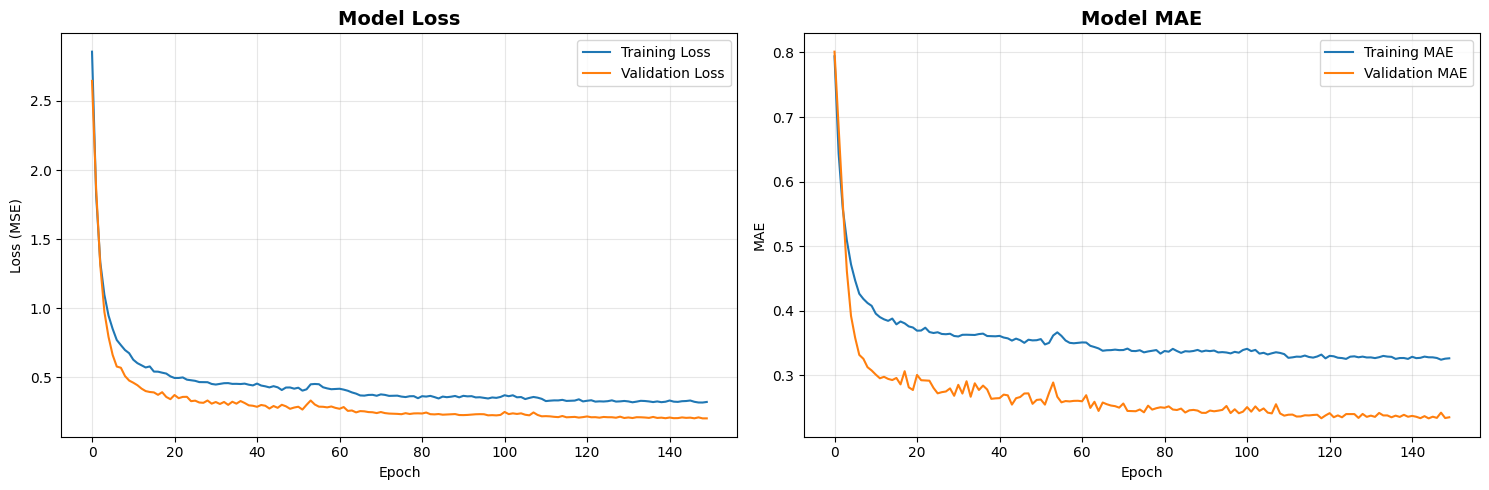

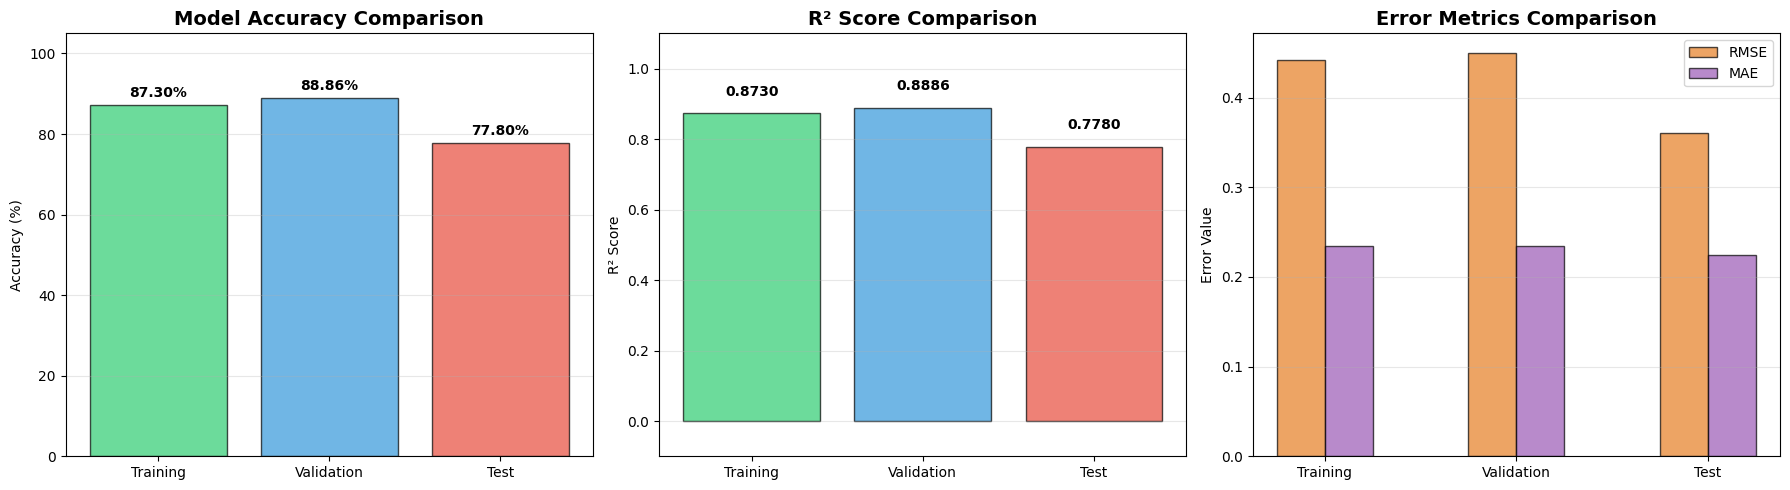

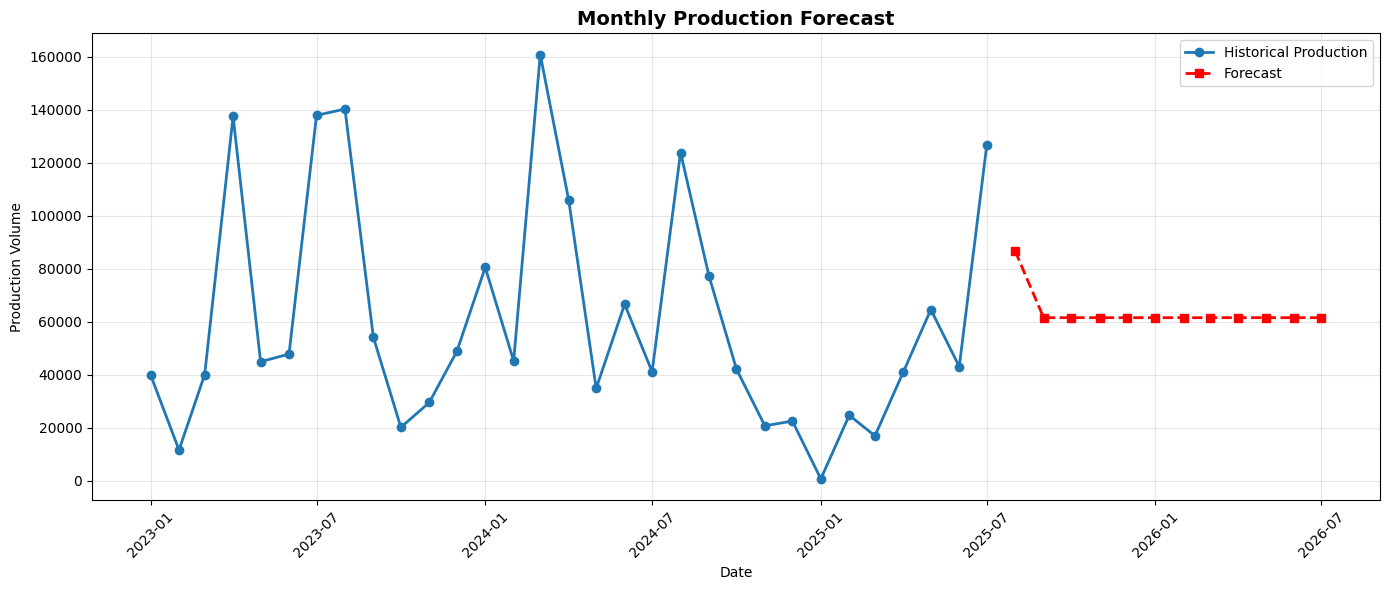

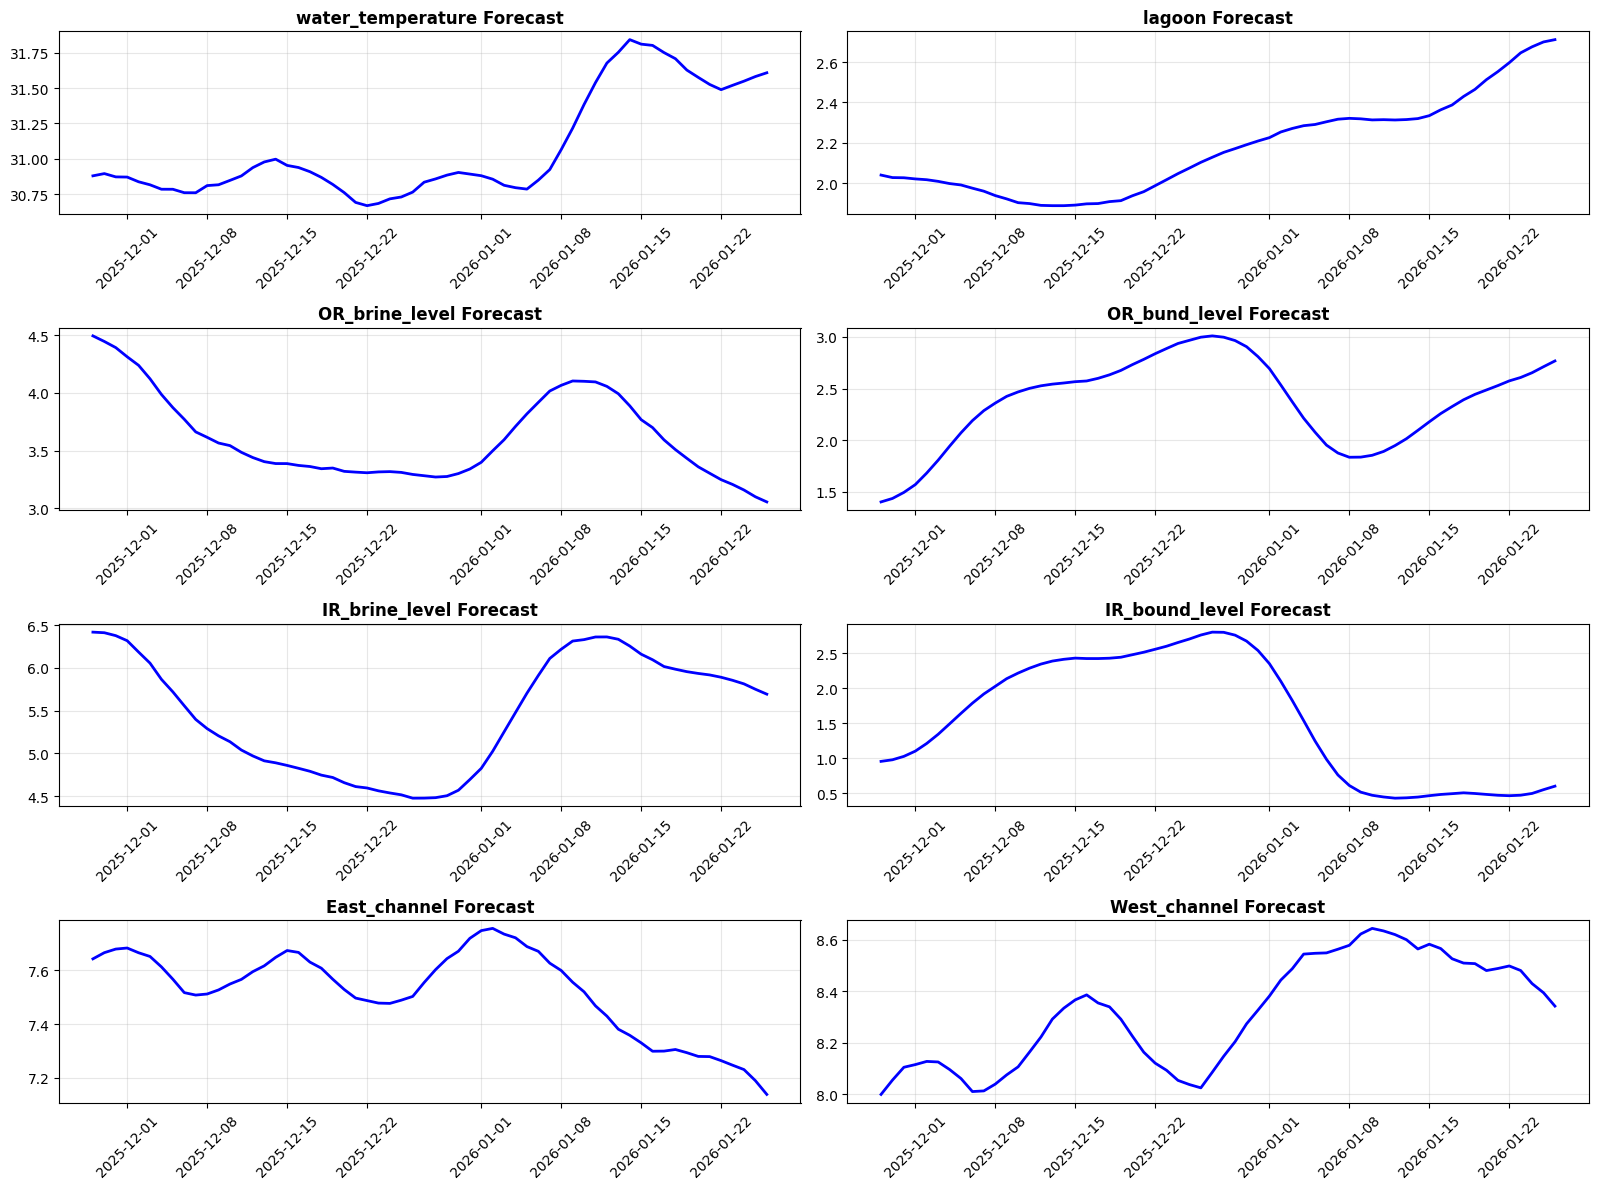


SAVING RESULTS
✓ Created folder: results/
✓ Saved: results/daily_parameters_forecast.csv
✓ Saved: results/monthly_production_forecast.csv
✓ Saved: results/12month_production_forecast.csv
✓ Saved: results/seasonal_totals_forecast.csv
✓ Saved: results/model_metrics.csv
✓ Saved: results/complete_forecasts.xlsx

FORECASTING COMPLETE!
✓ Model saved: best_hybrid_model.keras
✓ All CSV and Excel files saved in 'results/' folder:
  - daily_parameters_forecast.csv
  - monthly_production_forecast.csv
  - 12month_production_forecast.csv
  - seasonal_totals_forecast.csv
  - model_metrics.csv
✓ Excel file saved: complete_forecasts.xlsx

FINAL MODEL SUMMARY
Test Accuracy:     77.80%
Test R² Score:     0.7780
Test RMSE:         0.360865
Test MAE:          0.224064

To use the model for new predictions, call:
forecast_parameters(model, log_scaler, weather_scaler, log_features,
                   weather_features, date, values)


In [29]:
# ============================================================
# 12. MAIN EXECUTION
# ============================================================

if __name__ == "__main__":
    print("="*60)
    print("SALT CRYSTALLIZATION FORECASTING SYSTEM")
    print("="*60)

    # First, let's inspect the data files
    print("\n" + "="*60)
    print("DATA FILE INSPECTION")
    print("="*60)

    try:
        # Try to load and inspect each file
        encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']

        for filename in ['log_data_total.csv', 'weather_data_total.csv',
                        'aggregated_data_total.csv', 'production_data_total.csv']:
            print(f"\nInspecting {filename}...")
            for encoding in encodings:
                try:
                    df = pd.read_csv(filename, encoding=encoding, nrows=5)
                    print(f"  ✓ Successfully read with {encoding}")
                    print(f"  Columns: {df.columns.tolist()}")
                    print(f"  Shape: {df.shape}")
                    break
                except:
                    continue
    except Exception as e:
        print(f"Inspection error: {e}")

    print("\n" + "="*60)
    print("STARTING MODEL TRAINING")
    print("="*60)

    try:
        # Train models
        model, arima_model, log_scaler, weather_scaler, log_features, weather_features, history, prod_df, metrics = train_models()

        # Example: Forecast with current values
        current_date = "2025-11-27"
        current_log_values = {
            'water_temperature': 28.5,
            'lagoon': 2.0,
            'OR_brine_level': 4.5,
            'OR_bund_level': 1.5,
            'IR_brine_level': 5.5,
            'IR_bound_level': 1.5,
            'East_channel': 7.0,
            'West_channel': 6.5
        }

        # Forecast parameters
        param_forecast = forecast_parameters(
            model, log_scaler, weather_scaler, log_features, weather_features,
            current_date, current_log_values, lookback=30, forecast_days=60
        )

        # Forecast production
        monthly_prod_forecast = forecast_production(arima_model, prod_df, forecast_months=6)

        # Forecast seasonal production
        seasonal_totals, yearly_forecast = forecast_seasonal_production(arima_model, prod_df, forecast_months=12)

        # Visualize (now includes metrics)
        plot_results(history, prod_df, yearly_forecast, metrics, param_forecast)

        # Save results to CSV files
        print("\n" + "="*60)
        print("SAVING RESULTS")
        print("="*60)

        # Create results folder if it doesn't exist
        import os
        results_folder = 'results'
        if not os.path.exists(results_folder):
            os.makedirs(results_folder)
            print(f"✓ Created folder: {results_folder}/")

        if param_forecast is not None:
            param_forecast.to_csv(f'{results_folder}/daily_parameters_forecast.csv', index=False)
            print(f"✓ Saved: {results_folder}/daily_parameters_forecast.csv")

        monthly_prod_forecast.to_csv(f'{results_folder}/monthly_production_forecast.csv', index=False)
        print(f"✓ Saved: {results_folder}/monthly_production_forecast.csv")

        yearly_forecast.to_csv(f'{results_folder}/12month_production_forecast.csv', index=False)
        print(f"✓ Saved: {results_folder}/12month_production_forecast.csv")

        seasonal_totals.to_frame('total_production').to_csv(f'{results_folder}/seasonal_totals_forecast.csv')
        print(f"✓ Saved: {results_folder}/seasonal_totals_forecast.csv")

        # Save model metrics
        metrics_df = pd.DataFrame(metrics).T
        metrics_df.to_csv(f'{results_folder}/model_metrics.csv')
        print(f"✓ Saved: {results_folder}/model_metrics.csv")

        # Also save to Excel for convenience
        with pd.ExcelWriter(f'{results_folder}/complete_forecasts.xlsx') as writer:
            if param_forecast is not None:
                param_forecast.to_excel(writer, sheet_name='Daily_Parameters', index=False)
            monthly_prod_forecast.to_excel(writer, sheet_name='Monthly_Production', index=False)
            yearly_forecast.to_excel(writer, sheet_name='12Month_Production', index=False)
            seasonal_totals.to_frame('total_production').to_excel(writer, sheet_name='Seasonal_Totals')
            metrics_df.to_excel(writer, sheet_name='Model_Metrics')

        print(f"✓ Saved: {results_folder}/complete_forecasts.xlsx")

        print("\n" + "="*60)
        print("FORECASTING COMPLETE!")
        print("="*60)
        print("✓ Model saved: best_hybrid_model.keras")
        print(f"✓ All CSV and Excel files saved in '{results_folder}/' folder:")
        print("  - daily_parameters_forecast.csv")
        print("  - monthly_production_forecast.csv")
        print("  - 12month_production_forecast.csv")
        print("  - seasonal_totals_forecast.csv")
        print("  - model_metrics.csv")
        print("✓ Excel file saved: complete_forecasts.xlsx")
        print("\n" + "="*60)
        print("FINAL MODEL SUMMARY")
        print("="*60)
        print(f"Test Accuracy:     {metrics['test']['accuracy']:.2f}%")
        print(f"Test R² Score:     {metrics['test']['r2']:.4f}")
        print(f"Test RMSE:         {metrics['test']['rmse']:.6f}")
        print(f"Test MAE:          {metrics['test']['mae']:.6f}")
        print("="*60)
        print("\nTo use the model for new predictions, call:")
        print("forecast_parameters(model, log_scaler, weather_scaler, log_features,")
        print("                   weather_features, date, values)")

    except Exception as e:
        print(f"\n❌ Error during execution: {e}")
        import traceback
        traceback.print_exc()
        print("\nPlease check your data files and column names.")
